# ADS 509 Module 3: Group Comparison 

The task of comparing two groups of text is fundamental to textual analysis. There are innumerable applications: survey respondents from different segments of customers, speeches by different political parties, words used in Tweets by different constituencies, etc. In this assignment you will build code to effect comparisons between groups of text data, using the ideas learned in reading and lecture.

This assignment asks you to analyze the lyrics and Twitter descriptions for the two artists you selected in Module 1. If the results from that pull were not to your liking, you are welcome to use the zipped data from the “Assignment Materials” section. Specifically, you are asked to do the following: 

* Read in the data, normalize the text, and tokenize it. When you tokenize your Twitter descriptions, keep hashtags and emojis in your token set. 
* Calculate descriptive statistics on the two sets of lyrics and compare the results. 
* For each of the four corpora, find the words that are unique to that corpus. 
* Build word clouds for all four corpora. 

Each one of the analyses has a section dedicated to it below. Before beginning the analysis there is a section for you to read in the data and do your cleaning (tokenization and normalization). 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [1]:
import os
import re
import emoji
import pandas as pd

from collections import Counter, defaultdict
from nltk.corpus import stopwords
from string import punctuation
from wordcloud import WordCloud 

from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer


In [2]:
# Use this space for any additional import statements you need

from matplotlib import pyplot as plt
from nltk.tokenize import word_tokenize

In [3]:
# Place any addtional functions or constants you need here. 

# Some punctuation variations
punctuation = set(punctuation) # speeds up comparison
tw_punct = punctuation - {"#"}

# Stopwords
sw = stopwords.words("english")

# Two useful regex
whitespace_pattern = re.compile(r"\s+")
hashtag_pattern = re.compile(r"^#[0-9a-zA-Z]+")

# It's handy to have a full set of emojis
all_language_emojis = set()

for country in emoji.EMOJI_DATA : 
    for em in emoji.EMOJI_DATA[country] : 
        all_language_emojis.add(em)

# and now our functions
def descriptive_stats(tokens, num_tokens = 5, verbose=True) :
    """
        Given a list of tokens, print number of tokens, number of unique tokens, 
        number of characters, lexical diversity, and num_tokens most common
        tokens. Return a list of 
    """

    # Place your Module 2 solution here
    num_tokens = len(tokens)
    num_unique_tokens = len(set(tokens))
    if num_tokens > 0:
        lexical_diversity = num_unique_tokens / num_tokens
    else:
        lexical_diversity = 0.0
    num_characters = sum(len(token) for token in tokens)
    
    if verbose :        
        print(f"There are {num_tokens} tokens in the data.")
        print(f"There are {num_unique_tokens} unique tokens in the data.")
        print(f"There are {num_characters} characters in the data.")
        print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")
    
        # print the five most common tokens
        common_tokens = Counter(tokens).most_common(5)
        print("Most common tokens:")
        for token, count in common_tokens:
            print(f"{token}: {count}")
        
    return([num_tokens, num_unique_tokens,
            lexical_diversity,
            num_characters])
    
def contains_emoji(s):
    
    s = str(s)
    emojis = [ch for ch in s if emoji.is_emoji(ch)]

    return(len(emojis) > 0)


def remove_stop(tokens) :
    # modify this function to remove stopwords
    return [token for token in tokens if token.lower() not in sw]
 
def remove_punctuation(text, punct_set=tw_punct) : 
    return("".join([ch for ch in text if ch not in punct_set]))

def tokenize(text) : 
    """ Splitting on whitespace rather than the book's tokenize function. That 
        function will drop tokens like '#hashtag' or '2A', which we need for Twitter. """
    
    # modify this function to return tokens
    return re.split(whitespace_pattern, text)

def prepare(text, pipeline) : 
    tokens = str(text)
    
    for transform in pipeline : 
        tokens = transform(tokens)
        
    return(tokens)


## Data Ingestion

Use this section to ingest your data into the data structures you plan to use. Typically this will be a dictionary or a pandas DataFrame.

In [4]:
# Feel fre to use the below cells as an example or read in the data in a way you prefer

data_location = "C:\\Users\\gauth\\Documents\\Harini\\San Diego University\\applied text mining\\M1 Assignment Data\\M1 Results\\" # change to your location if it is not in the same directory as your notebook
twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

artist_files = {'cher':'cher_followers_data.txt',
                'robyn':'robynkonichiwa_followers_data.txt'}


In [5]:
twitter_data = pd.read_csv(data_location + twitter_folder + artist_files['cher'],
                           sep="\t",
                           quoting=3)

twitter_data['artist'] = "cher"

In [6]:
twitter_data_2 = pd.read_csv(data_location + twitter_folder + artist_files['robyn'],
                             sep="\t",
                             quoting=3)
twitter_data_2['artist'] = "robyn"

twitter_data = pd.concat([
    twitter_data,twitter_data_2])
    
del(twitter_data_2)

In [7]:
lyrics_data = {}

# Read in the lyrics data
lyrics_path = os.path.join(data_location, lyrics_folder)

# Iterate over artist folders
for artist_folder in os.listdir(lyrics_path):
    artist_folder_path = os.path.join(lyrics_path, artist_folder)
    
    # Check if the item is a directory
    if os.path.isdir(artist_folder_path):
        artist_lyrics = []
        
        # Iterate over files within the artist folder
        for file_name in os.listdir(artist_folder_path):
            file_path = os.path.join(artist_folder_path, file_name)
            
            # Check if the item is a file
            if os.path.isfile(file_path):
                with open(file_path, 'r') as file:
                    lyrics = file.read()
                    
                    # Store the lyrics in the list for the current artist
                    artist_lyrics.append(lyrics)
        
        # Store the list of lyrics for the current artist in the lyrics_data dictionary
        lyrics_data[artist_folder] = artist_lyrics

## Tokenization and Normalization

In this next section, tokenize and normalize your data. We recommend the following cleaning. 

**Lyrics** 

* Remove song titles
* Casefold to lowercase
* Remove stopwords (optional)
* Remove punctuation
* Split on whitespace

Removal of stopwords is up to you. Your descriptive statistic comparison will be different if you include stopwords, though TF-IDF should still find interesting features for you. Note that we remove stopwords before removing punctuation because the stopword set includes punctuation.

**Twitter Descriptions** 

* Casefold to lowercase
* Remove stopwords
* Remove punctuation other than emojis or hashtags
* Split on whitespace

Removing stopwords seems sensible for the Twitter description data. Remember to leave in emojis and hashtags, since you analyze those. 

In [8]:
# apply the `pipeline` techniques from BTAP Ch 1 or 5

my_pipeline = [str.lower, remove_punctuation, tokenize, remove_stop]

# Create a new dictionary to store the tokenized lyrics and number of tokens
tokenized_lyrics_data = {}

# Iterate over the artists in lyrics_data
for artist, lyrics in lyrics_data.items():
    # Apply the pipeline to the list of lyrics for the current artist
    tokens = [prepare(lyric, pipeline=my_pipeline) for lyric in lyrics]
    tokenized_lyrics_data[artist] = tokens

    # Add a new key to store the number of tokens for each artist
    tokenized_lyrics_data[f"{artist}_num_tokens"] = [len(token_list) for token_list in tokens]

twitter_data["tokens"] = twitter_data["description"].apply(prepare,pipeline=my_pipeline)
twitter_data["num_tokens"] = twitter_data["tokens"].map(len) 


In [9]:
twitter_data['has_emoji'] = twitter_data["description"].apply(contains_emoji)

Let's take a quick look at some descriptions with emojis.

In [10]:
twitter_data[twitter_data.has_emoji].sample(10)[["artist","description","tokens"]]

,artist,description,tokens
738866,cher,22. TST👹. ♌️. BMP👩‍❤️‍💋‍👨. 🌃Community Outreach...,"[22, tst👹, ♌️, bmp👩‍❤️‍💋‍👨, 🌃community, outrea..."
101906,cher,"libra in the brain, swag in the veins 🥶","[libra, brain, swag, veins, 🥶]"
512044,cher,Costarricense 🇨🇷 Leonino 🦁 Xeneize 💙💛💙 En una ...,"[costarricense, 🇨🇷, leonino, 🦁, xeneize, 💙💛💙, ..."
3700487,cher,21. Aussie. Lady Gaga is pretty much my life. ✌,"[21, aussie, lady, gaga, pretty, much, life, ✌]"
913142,cher,#BlackLivesMatter | #UT22 🏳️‍🌈 | Government 🗳 ...,"[#blacklivesmatter, #ut22, 🏳️‍🌈, government, 🗳..."
432060,cher,"Professora, leitora voraz, geek, nordestina. 🌙...","[professora, leitora, voraz, geek, nordestina,..."
1035872,cher,abolish the police. #RadicalHope #blacklivesma...,"[abolish, police, #radicalhope, #blacklivesmat..."
3984324,cher,"♥Solo TU puedes cambiar el mundo, empieza muy ...","[♥solo, tu, puedes, cambiar, el, mundo, empiez..."
410718,cher,With all the poop in the world....... Who deci...,"[poop, world, decided, 🦇💩, craziest]"
3247037,cher,🦋show me what you are made ofツ,"[🦋show, made, ofツ]"




Q: What is one area of improvement to your tokenization that you could theoretically carry out? (No need to actually do it; let's not make perfect the enemy of good enough.)

A: Here are several places where tokenization can be improved upon in light of the results mentioned above. Emojis can be broken apart rather than grouped together, and in cases where there is she/her, that should be broken into individual tokens rather than sheher. Multi-word expressions like Katy Perry should be considered as distinct tokens.

## Calculate descriptive statistics on the two sets of lyrics and compare the results. 


In [11]:
# your code here

# Calculate descriptive statistics for the first set of lyrics
cher_tokens = [token for lyric_tokens in tokenized_lyrics_data["cher"] for token in lyric_tokens]
cher_stats = descriptive_stats(cher_tokens, verbose=False)

# Calculate descriptive statistics for the second set of lyrics
robyn_tokens = [token for lyric_tokens in tokenized_lyrics_data["robyn"] for token in lyric_tokens]
robyn_stats = descriptive_stats(robyn_tokens, verbose=False)

# Print the stats for comparison
print("Descriptive Statistics - Cher:")
print(f"Number of Tokens: {cher_stats[0]}")
print(f"Number of Unique Tokens: {cher_stats[1]}")
print(f"Lexical Diversity: {cher_stats[2]:.3f}")
print(f"Number of Characters: {cher_stats[3]}")
print()

print("Descriptive Statistics - Robyn:")
print(f"Number of Tokens: {robyn_stats[0]}")
print(f"Number of Unique Tokens: {robyn_stats[1]}")
print(f"Lexical Diversity: {robyn_stats[2]:.3f}")
print(f"Number of Characters: {robyn_stats[3]}")

Descriptive Statistics - Cher:
Number of Tokens: 36232
Number of Unique Tokens: 3704
Lexical Diversity: 0.102
Number of Characters: 172696

Descriptive Statistics - Robyn:
Number of Tokens: 15331
Number of Unique Tokens: 2157
Lexical Diversity: 0.141
Number of Characters: 73988


Q: what observations do you make about these data? 

A: The top 5 words in the lyrics of both Cher and Robyn are the same. It's fascinating to note that Robyn's lyrics have a wider variety of vocabularies than Cher's. It's intriguing that the two artists' tweets also exhibit this linguistic variety tendency.


## Find tokens uniquely related to a corpus

Typically we would use TF-IDF to find unique tokens in documents. Unfortunately, we either have too few documents (if we view each data source as a single document) or too many (if we view each description as a separate document). In the latter case, our problem will be that descriptions tend to be short, so our matrix would be too sparse to support analysis. 

To avoid these problems, we will create a custom statistic to identify words that are uniquely related to each corpus. The idea is to find words that occur often in one corpus and infrequently in the other(s). Since corpora can be of different lengths, we will focus on the _concentration_ of tokens within a corpus. "Concentration" is simply the count of the token divided by the total corpus length. For instance, if a corpus had length 100,000 and a word appeared 1,000 times, then the concentration would be $\frac{1000}{100000} = 0.01$. If the same token had a concentration of $0.005$ in another corpus, then the concentration ratio would be $\frac{0.01}{0.005} = 2$. Very rare words can easily create infinite ratios, so you will also add a cutoff to your code so that a token must appear at least $n$ times for you to return it. 

An example of these calculations can be found in [this spreadsheet](https://docs.google.com/spreadsheets/d/1P87fkyslJhqXFnfYezNYrDrXp_GS8gwSATsZymv-9ms). Please don't hesitate to ask questions if this is confusing. 

In this section find 10 tokens for each of your four corpora that meet the following criteria: 

1. The token appears at least `n` times in all corpora
1. The tokens are in the top 10 for the highest ratio of appearances in a given corpora vs appearances in other corpora.

You will choose a cutoff for yourself based on the side of the corpus you're working with. If you're working with the Robyn-Cher corpora provided, `n=5` seems to perform reasonably well.

In [12]:
# your code here

n = 5  # Minimum number of occurrences for a token to be considered

cher_tweet_tokens = [tweet.split() for tweet in twitter_data[twitter_data['artist'] == 'cher']['tokens'].astype(str)]
robyn_tweet_tokens = [tweet.split() for tweet in twitter_data[twitter_data['artist'] == 'robyn']['tokens'].astype(str)]

corpus_tokens = {
    "cher": cher_tokens,
    "robyn": robyn_tokens,
    "cher_tweet": [' '.join(token).replace("['", "").replace("']", "") for token in cher_tweet_tokens],
    "robyn_tweet": [' '.join(token).replace("['", "").replace("']", "") for token in robyn_tweet_tokens]
}

top_tokens = {}

# Calculate concentration ratios for each token in each corpus
for corpus, tokens in corpus_tokens.items():
    token_counts = Counter(tokens)
    total_corpus_length = len(tokens)
    corpus_ratios = {}
    
    for token, count in token_counts.items():
        if count >= n:
            concentration = count / total_corpus_length
            other_ratios = [
                (other_corpus, other_counts.count(token) / len(corpus_tokens[other_corpus]))
                for other_corpus, other_counts in corpus_tokens.items()
                if other_corpus != corpus and token in other_counts and other_counts.count(token) >= n
            ]
            
            if other_ratios:
                max_ratio = max(other_ratios, key=lambda x: x[1])[1]
                ratio = concentration / max_ratio
                corpus_ratios[token] = ratio
    
    top_tokens[corpus] = sorted(corpus_ratios.items(), key=lambda x: x[1], reverse=True)[:10]

# Print the top tokens for each corpus
for corpus, tokens in top_tokens.items():
    print(f"Top Tokens for {corpus}:")
    for token, ratio in tokens:
        print(f"{token}: {ratio:.3f}")
    print()

Top Tokens for cher:
lonely: 735.041
must: 716.665
crying: 705.640
late: 661.537
broken: 612.534
red: 598.534
forget: 588.033
roll: 588.033
young: 573.332
found: 529.230

Top Tokens for robyn:
jack: 1302.851
beach: 781.711
girlfriend: 573.255
fact: 573.255
healthy: 573.255
check: 553.712
boom: 551.206
imma: 521.141
loud: 312.684
style: 303.999

Top Tokens for cher_tweet:
retired: 12.380
male: 4.893
female: 4.862
funny: 4.073
love', 'family: 3.893
loving', 'life: 3.264
18: 2.922
living', 'dream: 2.641
live', 'life', 'fullest: 2.637
life', 'good: 2.563

Top Tokens for robyn_tweet:
hej: 166.193
sweden: 48.768
tja: 33.441
dj', 'producer', 'remixer: 26.753
musik: 22.825
djproducer: 19.198
dj', 'producer: 18.048
nej: 13.377
songwriterproducer: 13.377
record', 'label: 12.160



Q: What are some observations about the top tokens? Do you notice any interesting items on the list? 

A: I noted that Robyn's tweets included more Swedish-specific terminology than Cher's, which had a more American focus in their substance. Robyn's lyrics seem to have a stronger dancing element, as well, I noted.

## Build word clouds for all four corpora. 

For building wordclouds, we'll follow exactly the code of the text. The code in this section can be found [here](https://github.com/blueprints-for-text-analytics-python/blueprints-text/blob/master/ch01/First_Insights.ipynb). If you haven't already, you should absolutely clone the repository that accompanies the book. 


In [13]:
from matplotlib import pyplot as plt

def preprocess(tokens):
    processed_tokens = []
    for token in tokens:
        if token not in ['[', ']', '']:
            # Concatenate individual characters within the token
            processed_token = ' '.join(token)
            # Remove square brackets and single quotes
            processed_token = processed_token.replace('[', '').replace(']', '').replace("'", '')
            processed_tokens.append(processed_token)
    return processed_tokens

def wordcloud(word_freq, title=None, max_words=200, stopwords=None):

    wc = WordCloud(width=800, height=400, 
                   background_color= "black", colormap="Paired", 
                   max_font_size=150, max_words=max_words)
    
    # convert data frame into dict
    if isinstance(word_freq, pd.Series):
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    # filter stop words in frequency counter
    if stopwords is not None:
        counter = {token:freq for (token, freq) in counter.items() 
                              if token not in stopwords}
    wc.generate_from_frequencies(counter)
 
    plt.title(title) 
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    
def count_words(tokens, preprocess=None, min_freq=2):
    # process tokens and update counter
    def update(doc):
        doc_tokens = doc if preprocess is None else preprocess(doc)
        counter.update(doc_tokens)

    # create counter and run through all data
    counter = Counter()
    for token_list in tokens:
        update(token_list)

    # Transform counter into dictionary
    freq_dict = {token: freq for token, freq in counter.items() if freq >= min_freq}

    return freq_dict

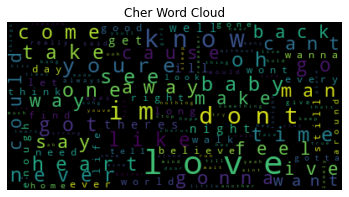

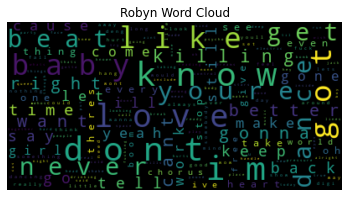

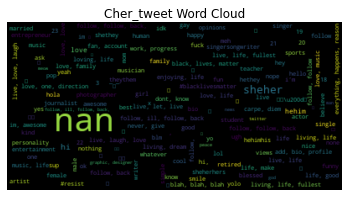

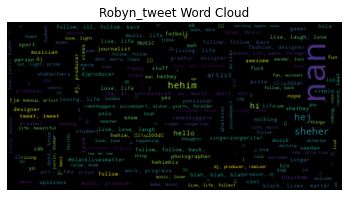

In [15]:
# Build the word clouds
from wordcloud import WordCloud
import wordcloud

corpus_tokens = {
    "cher": cher_tokens,
    "robyn": robyn_tokens,
    "cher_tweet": cher_tweet_tokens,
    "robyn_tweet": robyn_tweet_tokens
}

# Convert to series
cher_tweet_tokens = pd.Series(cher_tweet_tokens)
robyn_tweet_tokens = pd.Series(robyn_tweet_tokens)

# Count the frequencies of the tokens
cher_word_freq = count_words(cher_tweet_tokens, preprocess=preprocess)
robyn_word_freq = count_words(robyn_tweet_tokens, preprocess=preprocess)

# Set the stopwords (if needed)
stopwords = []

# Generate word clouds
for corpus, tokens in corpus_tokens.items():
    processed_tokens = preprocess(tokens)
    token_counts = Counter(processed_tokens)

    # Create a WordCloud object
    wordcloud = WordCloud(max_font_size=40, stopwords=stopwords)

    # Generate the word cloud
    wordcloud.generate_from_frequencies(token_counts)

    # Save the word cloud
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"{corpus.capitalize()} Word Cloud")
    plt.savefig(f"{corpus}_word_cloud.png")





Q: What observations do you have about these (relatively straightforward) wordclouds? 

A: The word cloud for the lyrics to Robyn vs. Cher shows a lot of repetition. They both feature terms like "love," "don't," "like," "know," "baby," and "youre" that are among the longest. The largest word in the tweets from both artists is nan, and I can also see other words like hehim, sheher, hi, love, and more, but they are all smaller than nan.